# TODO:
- don't use test set also for validation
- create latex table out of scores

In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split, KFold
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [56]:
from utils import *

# Import data

In [3]:
FOLDS = 5 # number of folds for CV (== number of fusions tried)
SEED = 2022

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
# import data
data = import_data()

In [11]:
%%time
# preproc data
# proc
data.iloc[:, 0] = data.iloc[:, 0].apply(lambda x: x.replace("<br />", " ")) # remove break symbols
data.iloc[:, 0] = data.iloc[:, 0].apply(lambda x: x.lower()) # all lower case

# only use short sentences
data["len"] = data.iloc[:, 0].apply(lambda x: len(x.split()))
data = data[data["len"] < 256]

# tokenize data (split sentence into tokens)
tokenizer = Tokenizer()
print("Tokenizing the data...")
data["len"] = data.iloc[:, 0].apply(lambda x: len(tokenizer.tokenize(x)))

# only use short sentences
data = data[data["len"] < 256]

# dataset size
print("Length of the data : ", len(data))

# further proc
data.iloc[:, 0] = data.iloc[:, 0].apply(
    lambda row: re.sub("[^A-Za-z]+", " ", row)).apply(tokenizer.tokenize)

# reset index (we deleted some rows)
data = data.reset_index(drop=True)

Tokenizing the data...
Length of the data :  29544
CPU times: total: 3min 47s
Wall time: 3min 49s


In [35]:
%%time
# data split (CV)
datasets = []
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for i, (train_indices, test_indices) in enumerate(cv.split(data)):
    train_set, test_set = data.loc[train_indices, :], data.loc[test_indices, :]

    datasets.append((train_set, test_set))

CPU times: total: 15.6 ms
Wall time: 24 ms


In [36]:
# create data generators
def build_generators(train, test, device, batch_size=512):
    # build vocab
    vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2}
    for item in train.iloc[:, 0]:
        for word in item:
            if word not in vocab:
                vocab[word] = len(vocab)
    pad_idx = vocab['__PAD__']
    voc_size = len(vocab)
    print("Vocabulary Size : ", voc_size)

    # create embedding
    embedding = torch.nn.Embedding(voc_size, 16)

    # dataframe to tensor
    train_y = torch.tensor(train.iloc[:, 1].values.astype(np.float32), device=device)
    test_y = torch.tensor(test.iloc[:, 1].values.astype(np.float32), device=device)

    unk_ID = vocab["__UNK__"]

    train_x_tensor = []
    for idx, text_corpus in enumerate(tqdm(train.iloc[:, 0])):
        foo = []
        for token in text_corpus:
            word_ID = vocab.get(token, unk_ID)
            foo.append(word_ID)
        while len(foo) < 256:
            foo.append(vocab["__PAD__"])
        train_x_tensor.append(foo)


    test_x_tensor = []
    for idx, text_corpus in enumerate(tqdm(test.iloc[:, 0])):
        foo = []
        for token in text_corpus:
            word_ID = vocab.get(token, unk_ID)
            foo.append(word_ID)
        while len(foo) < 256:
            foo.append(vocab["__PAD__"])
        test_x_tensor.append(foo)

    train_x = torch.tensor(train_x_tensor, device=device)
    test_x = torch.tensor(test_x_tensor, device=device)

    train = torch.utils.data.TensorDataset(train_x, train_y)
    test = torch.utils.data.TensorDataset(test_x, test_y)

    train_iterator = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
    test_iterator = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = True)

    # check imbalance
    check_imbalance(train_iterator, name='train set')
    check_imbalance(test_iterator, name='test set')

    print('Dataset initializing done')
    return train_iterator, test_iterator, voc_size, pad_idx, embedding

# CV

### Definition

In [37]:
LEARNING_RATE = 2e-4 # starting learning rate for scheduler

In [43]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, embedding, pad_idx, voc_size, device, lr=2e-4, save=True):
    # init
    model = new_model(embedding, pad_idx, voc_size, device) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch='unrestricted',
                    clip=1,
                    device=device)

    if save:
        # save model
        name = f'parallel_training/model{model_name}_IMDB_256'
        save_model(model, name=name)

        # save history
        name = f'parallel_training/history_model{model_name}_IMDB_256'
        save_history(history, name=name)

    return model

### Evaluation

In [60]:
scores = {'loss': {'A': [], 'B': [], 'vanilla_pre': [], 'vanilla_post': [], 'OT_pre': [], 'OT_post': [], 'random': []},
          'accuracy': {'A': [], 'B': [], 'vanilla_pre': [], 'vanilla_post': [], 'OT_pre': [], 'OT_post': [], 'random': []}}

fold 1/5
Vocabulary Size :  23054


100%|██████████| 5909/5909 [00:00<00:00, 21066.07it/s]


Positive labels ratio (train set): 0.5059022635921303
Positive labels ratio (test set): 0.4902690810627856
Dataset initializing done
Starting training for model A


  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:211: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
Epoch: 91 - Train Loss: 0.1827 / Validation Loss: 0.5064 / Train acc: 0.9340 / Val acc: 0.8111 

Training has converged after 91 epochs (lr < 1e-06)


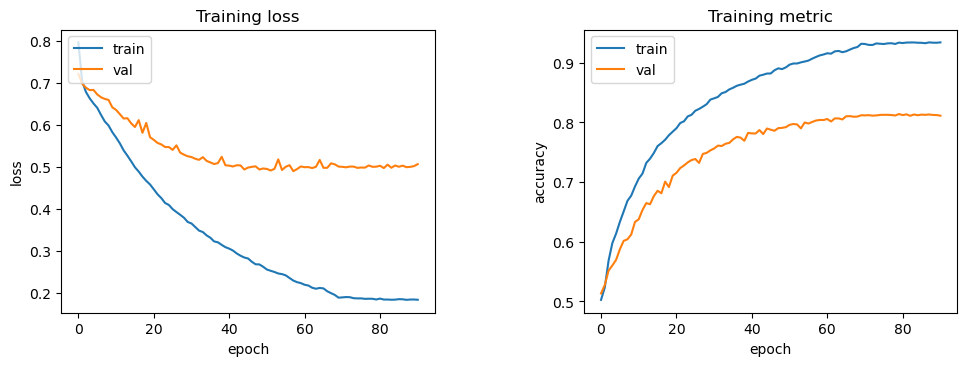

Epoch: 91 - Train Loss: 0.1827 / Validation Loss: 0.5064 / Train acc: 0.9340 / Val acc: 0.8111 / Learning Rate : 0.0000:   0%|          | 91/1000000 [03:19<608:04:02,  2.19s/it]


Starting training for model B


Epoch: 48 - Train Loss: 0.1586 / Validation Loss: 0.4067 / Train acc: 0.9448 / Val acc: 0.8483 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:45<605:26:41,  2.18s/it]

Training has converged after 48 epochs (lr < 1e-06)


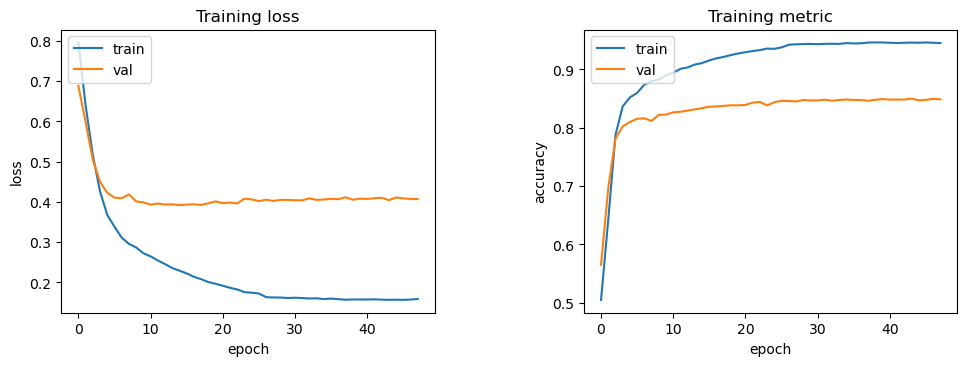

Epoch: 48 - Train Loss: 0.1586 / Validation Loss: 0.4067 / Train acc: 0.9448 / Val acc: 0.8483 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:45<608:50:21,  2.19s/it]


fusion successful
fusion successful
Starting retraining for model vanilla fusion


Epoch: 366 - Train Loss: 0.6026 / Validation Loss: 0.8584 / Train acc: 0.7162 / Val acc: 0.6761 / Learning Rate : 0.0000:   0%|          | 366/1000000 [12:42<576:11:28,  2.08s/it]

Training has converged after 366 epochs (lr < 1e-06)


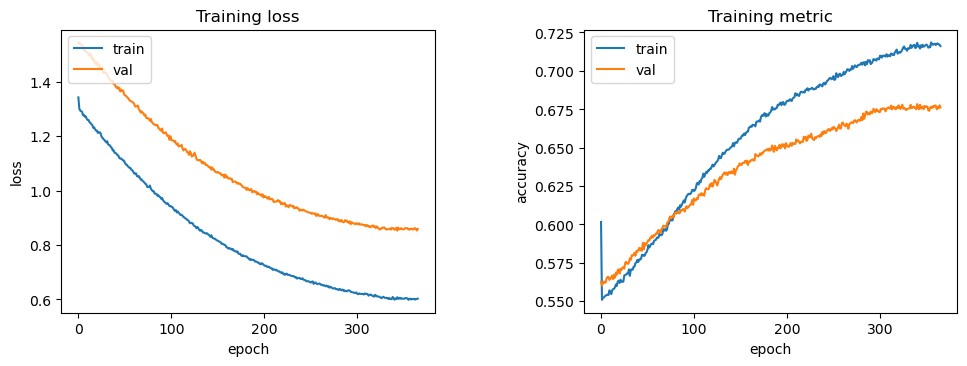

Epoch: 366 - Train Loss: 0.6026 / Validation Loss: 0.8584 / Train acc: 0.7162 / Val acc: 0.6761 / Learning Rate : 0.0000:   0%|          | 366/1000000 [12:42<578:30:50,  2.08s/it]


Starting retraining for model OT fusion


Epoch: 148 - Train Loss: 0.2165 / Validation Loss: 0.4563 / Train acc: 0.9288 / Val acc: 0.7975 / Learning Rate : 0.0000:   0%|          | 148/1000000 [05:07<575:20:21,  2.07s/it]

Training has converged after 148 epochs (lr < 1e-06)


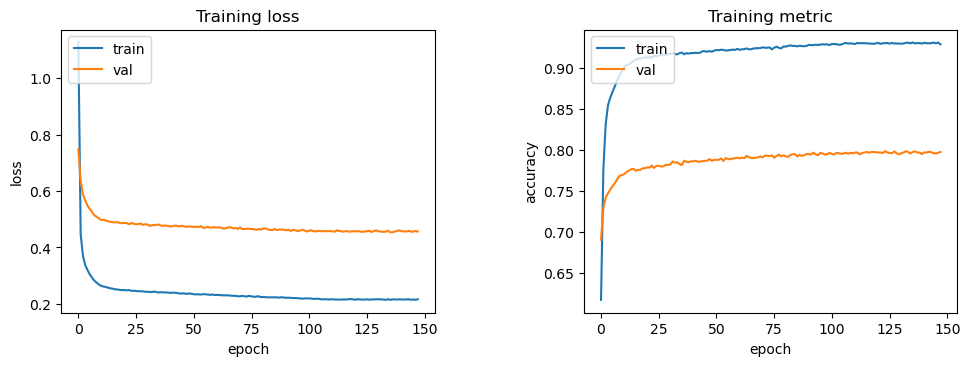

Epoch: 148 - Train Loss: 0.2165 / Validation Loss: 0.4563 / Train acc: 0.9288 / Val acc: 0.7975 / Learning Rate : 0.0000:   0%|          | 148/1000000 [05:08<578:20:43,  2.08s/it]


fold 2/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 22172.65it/s]


Positive labels ratio (train set): 0.5016289401311614
Positive labels ratio (test set): 0.5073616517177187
Dataset initializing done
Starting training for model A


Epoch: 91 - Train Loss: 0.1811 / Validation Loss: 0.5050 / Train acc: 0.9338 / Val acc: 0.8042 / Learning Rate : 0.0000:   0%|          | 91/1000000 [03:17<600:46:51,  2.16s/it]

Training has converged after 91 epochs (lr < 1e-06)


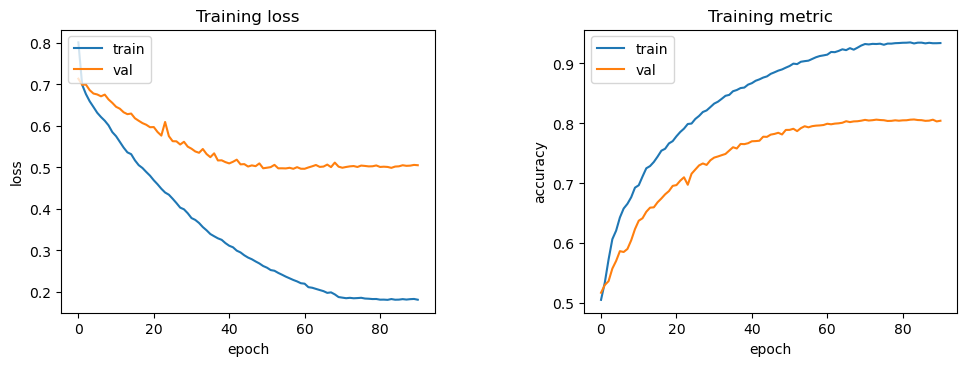

Epoch: 91 - Train Loss: 0.1811 / Validation Loss: 0.5050 / Train acc: 0.9338 / Val acc: 0.8042 / Learning Rate : 0.0000:   0%|          | 91/1000000 [03:17<603:57:16,  2.17s/it]


Starting training for model B


Epoch: 46 - Train Loss: 0.1599 / Validation Loss: 0.4141 / Train acc: 0.9432 / Val acc: 0.8340 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:40<606:36:23,  2.18s/it]

Training has converged after 46 epochs (lr < 1e-06)


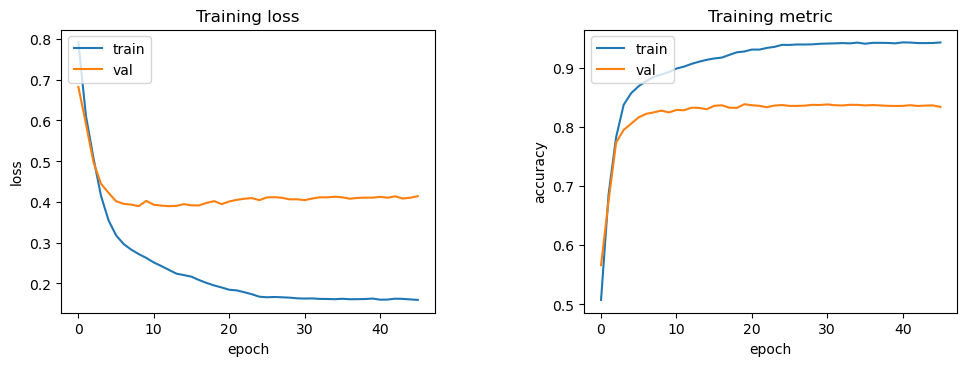

Epoch: 46 - Train Loss: 0.1599 / Validation Loss: 0.4141 / Train acc: 0.9432 / Val acc: 0.8340 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:40<605:30:45,  2.18s/it]


fusion successful
fusion successful
Starting retraining for model vanilla fusion


Epoch: 244 - Train Loss: 0.4289 / Validation Loss: 0.7023 / Train acc: 0.7864 / Val acc: 0.7111 / Learning Rate : 0.0000:   0%|          | 244/1000000 [08:28<587:25:44,  2.12s/it]

Training has converged after 244 epochs (lr < 1e-06)


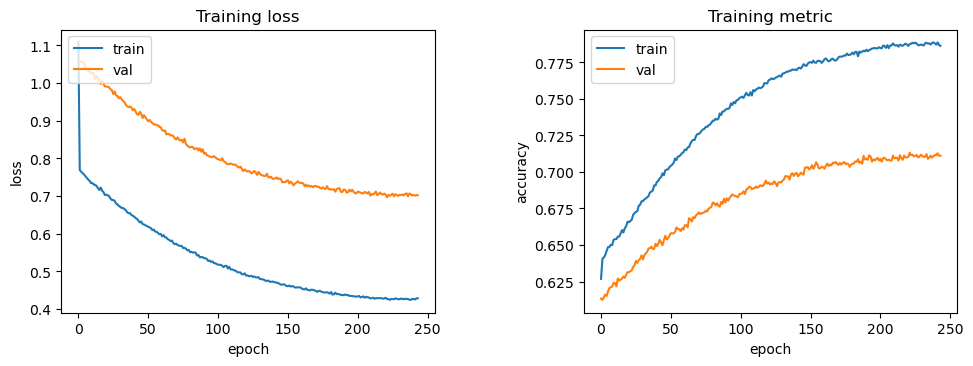

Epoch: 244 - Train Loss: 0.4289 / Validation Loss: 0.7023 / Train acc: 0.7864 / Val acc: 0.7111 / Learning Rate : 0.0000:   0%|          | 244/1000000 [08:28<578:51:24,  2.08s/it]


Starting retraining for model OT fusion


Epoch: 122 - Train Loss: 0.2088 / Validation Loss: 0.4633 / Train acc: 0.9300 / Val acc: 0.8000 / Learning Rate : 0.0000:   0%|          | 122/1000000 [04:13<575:15:23,  2.07s/it]

Training has converged after 122 epochs (lr < 1e-06)


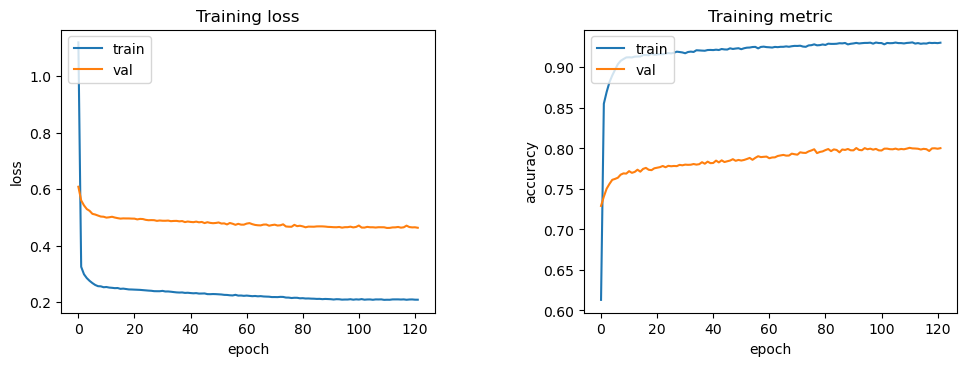

Epoch: 122 - Train Loss: 0.2088 / Validation Loss: 0.4633 / Train acc: 0.9300 / Val acc: 0.8000 / Learning Rate : 0.0000:   0%|          | 122/1000000 [04:13<577:30:08,  2.08s/it]


fold 3/5
Vocabulary Size :  23075


100%|██████████| 5909/5909 [00:00<00:00, 23541.97it/s]


Positive labels ratio (train set): 0.5009519779987307
Positive labels ratio (test set): 0.5100693856828566
Dataset initializing done
Starting training for model A


Epoch: 92 - Train Loss: 0.1878 / Validation Loss: 0.5103 / Train acc: 0.9293 / Val acc: 0.8013 / Learning Rate : 0.0000:   0%|          | 92/1000000 [03:21<605:38:16,  2.18s/it]

Training has converged after 92 epochs (lr < 1e-06)


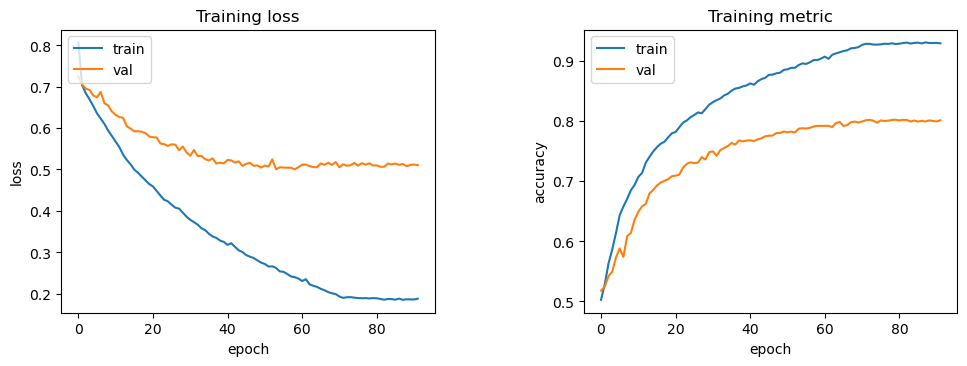

Epoch: 92 - Train Loss: 0.1878 / Validation Loss: 0.5103 / Train acc: 0.9293 / Val acc: 0.8013 / Learning Rate : 0.0000:   0%|          | 92/1000000 [03:21<609:30:05,  2.19s/it]


Starting training for model B


Epoch: 45 - Train Loss: 0.1675 / Validation Loss: 0.4157 / Train acc: 0.9371 / Val acc: 0.8316 / Learning Rate : 0.0000:   0%|          | 45/1000000 [01:38<606:55:47,  2.19s/it]

Training has converged after 45 epochs (lr < 1e-06)


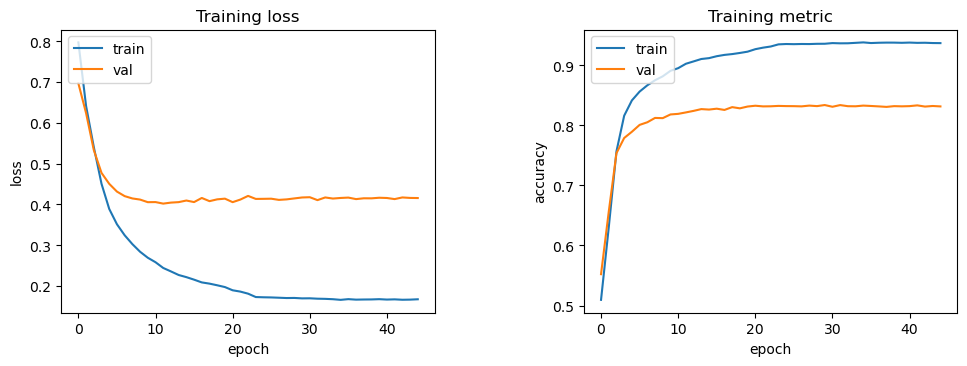

Epoch: 45 - Train Loss: 0.1675 / Validation Loss: 0.4157 / Train acc: 0.9371 / Val acc: 0.8316 / Learning Rate : 0.0000:   0%|          | 45/1000000 [01:38<609:28:54,  2.19s/it]


fusion successful
fusion successful
Starting retraining for model vanilla fusion


Epoch: 174 - Train Loss: 0.2629 / Validation Loss: 0.5313 / Train acc: 0.8891 / Val acc: 0.7760 / Learning Rate : 0.0000:   0%|          | 174/1000000 [06:10<594:14:40,  2.14s/it]

Training has converged after 174 epochs (lr < 1e-06)


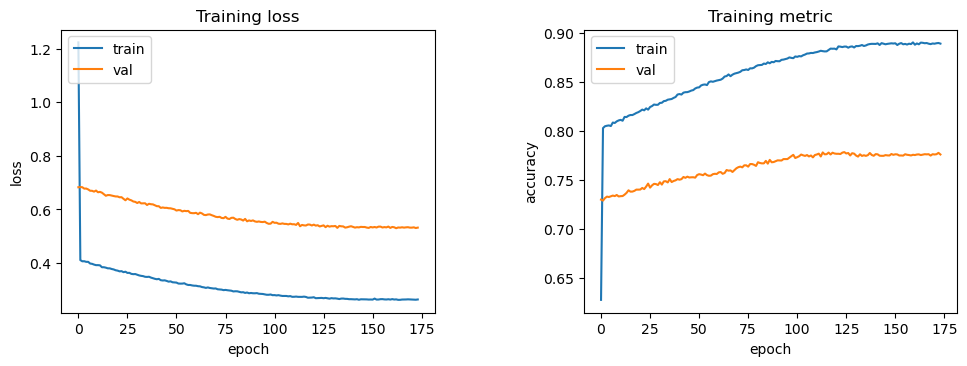

Epoch: 174 - Train Loss: 0.2629 / Validation Loss: 0.5313 / Train acc: 0.8891 / Val acc: 0.7760 / Learning Rate : 0.0000:   0%|          | 174/1000000 [06:10<591:01:07,  2.13s/it]


Starting retraining for model OT fusion


Epoch: 129 - Train Loss: 0.2079 / Validation Loss: 0.4623 / Train acc: 0.9299 / Val acc: 0.7949 / Learning Rate : 0.0000:   0%|          | 129/1000000 [04:39<618:03:53,  2.23s/it]

Training has converged after 129 epochs (lr < 1e-06)


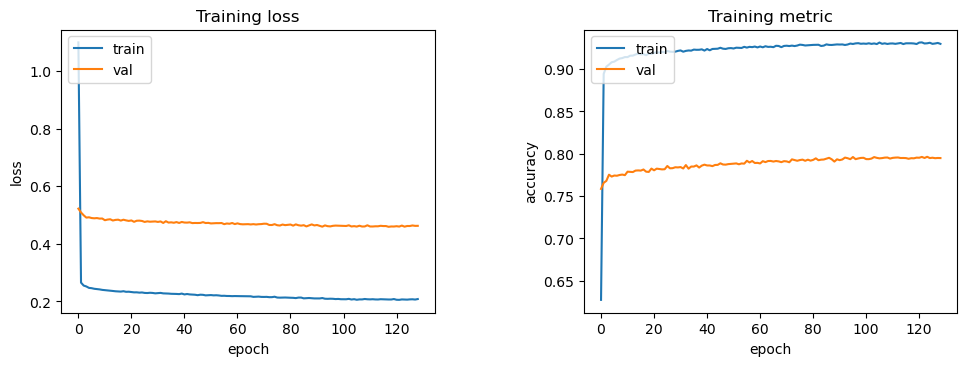

Epoch: 129 - Train Loss: 0.2079 / Validation Loss: 0.4623 / Train acc: 0.9299 / Val acc: 0.7949 / Learning Rate : 0.0000:   0%|          | 129/1000000 [04:39<601:13:53,  2.16s/it]


fold 4/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 22735.95it/s]


Positive labels ratio (train set): 0.503448275862069
Positive labels ratio (test set): 0.5000846166864106
Dataset initializing done
Starting training for model A


Epoch: 103 - Train Loss: 0.1518 / Validation Loss: 0.5047 / Train acc: 0.9475 / Val acc: 0.8103 / Learning Rate : 0.0000:   0%|          | 103/1000000 [04:09<710:07:49,  2.56s/it]

Training has converged after 103 epochs (lr < 1e-06)


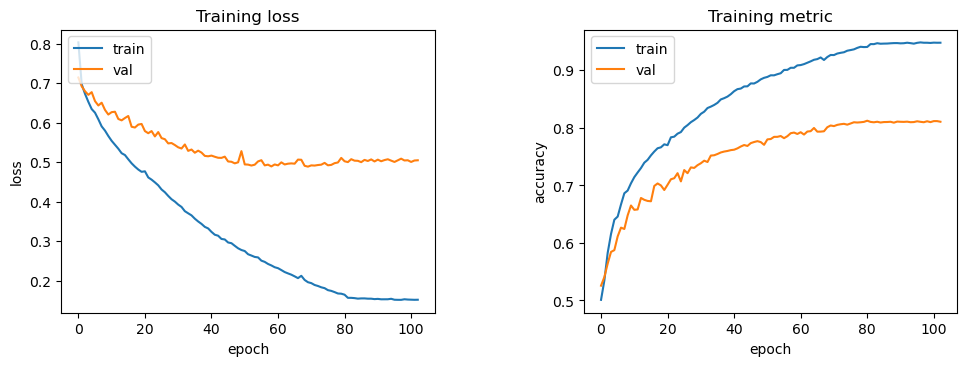

Epoch: 103 - Train Loss: 0.1518 / Validation Loss: 0.5047 / Train acc: 0.9475 / Val acc: 0.8103 / Learning Rate : 0.0000:   0%|          | 103/1000000 [04:09<673:52:14,  2.43s/it]


Starting training for model B


Epoch: 45 - Train Loss: 0.1548 / Validation Loss: 0.3979 / Train acc: 0.9461 / Val acc: 0.8365 / Learning Rate : 0.0000:   0%|          | 45/1000000 [01:53<678:52:20,  2.44s/it]

Training has converged after 45 epochs (lr < 1e-06)


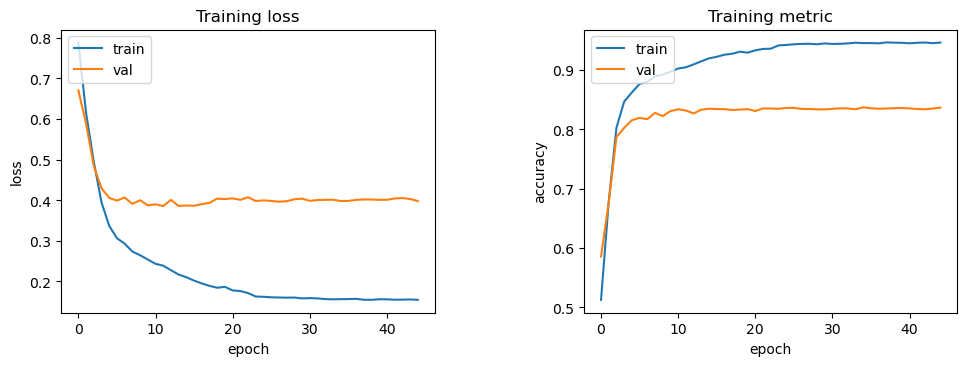

Epoch: 45 - Train Loss: 0.1548 / Validation Loss: 0.3979 / Train acc: 0.9461 / Val acc: 0.8365 / Learning Rate : 0.0000:   0%|          | 45/1000000 [01:53<700:51:48,  2.52s/it]


fusion successful
fusion successful
Starting retraining for model vanilla fusion


Epoch: 478 - Train Loss: 0.1961 / Validation Loss: 0.4700 / Train acc: 0.9317 / Val acc: 0.7990 / Learning Rate : 0.0000:   0%|          | 478/1000000 [18:06<580:09:32,  2.09s/it]

Training has converged after 478 epochs (lr < 1e-06)


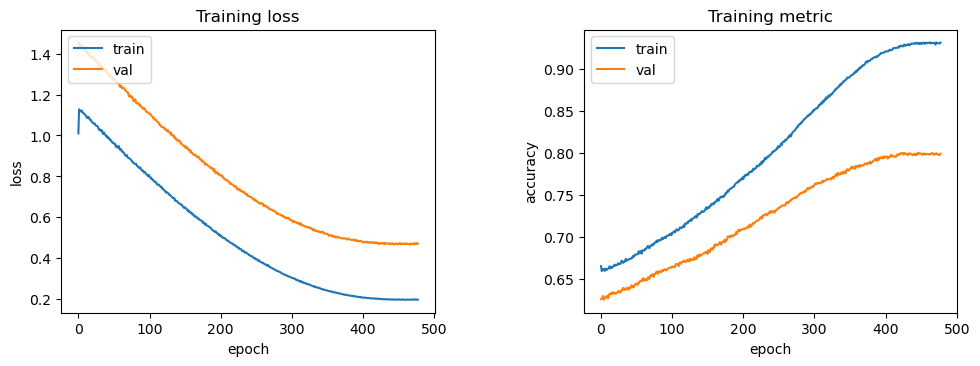

Epoch: 478 - Train Loss: 0.1961 / Validation Loss: 0.4700 / Train acc: 0.9317 / Val acc: 0.7990 / Learning Rate : 0.0000:   0%|          | 478/1000000 [18:06<631:06:44,  2.27s/it]


Starting retraining for model OT fusion


Epoch: 162 - Train Loss: 0.1943 / Validation Loss: 0.4603 / Train acc: 0.9362 / Val acc: 0.7992 / Learning Rate : 0.0000:   0%|          | 162/1000000 [05:37<574:40:00,  2.07s/it]

Training has converged after 162 epochs (lr < 1e-06)


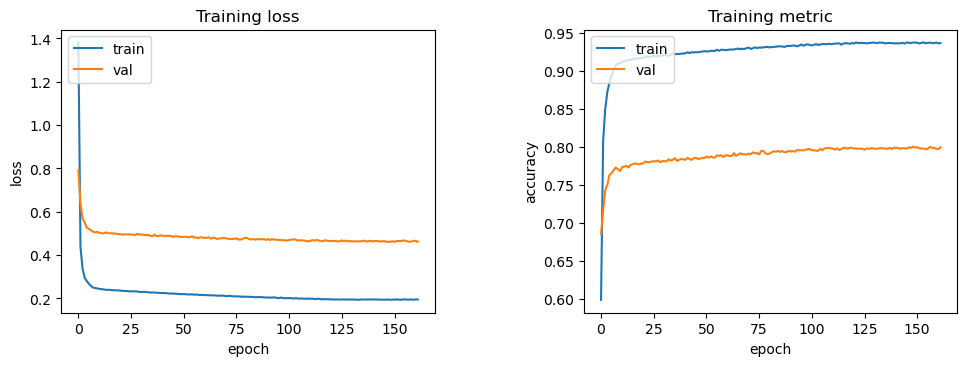

Epoch: 162 - Train Loss: 0.1943 / Validation Loss: 0.4603 / Train acc: 0.9362 / Val acc: 0.7992 / Learning Rate : 0.0000:   0%|          | 162/1000000 [05:37<578:24:33,  2.08s/it]


fold 5/5


IndexError: pop from empty list

In [61]:
%%time
for i in range(FOLDS):
    print(f'Fold {i + 1}/{FOLDS}')

    # get training, test set
    train_set, test_set = datasets.pop()

    # build generators
    train_iterator, test_iterator, voc_size, pad_idx, embedding = build_generators(train_set, test_set, device, batch_size=512)

    # train parent models
    print('Starting training for model A')
    modelA = train_early_stopping(model_name='A',
                                  train_iter=train_iterator,
                                  valid_iter=test_iterator,
                                  embedding=embedding,
                                  pad_idx=pad_idx,
                                  voc_size=voc_size,
                                  device=device,
                                  lr=LEARNING_RATE,
                                  save=False)
    print('Starting training for model B')
    modelB = train_early_stopping(model_name='B',
                                  train_iter=train_iterator,
                                  valid_iter=test_iterator,
                                  embedding=embedding,
                                  pad_idx=pad_idx,
                                  voc_size=voc_size,
                                  device=device,
                                  lr=LEARNING_RATE,
                                  save=False)

    # model fusion
    # 1) vanilla
    model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx, voc_size=voc_size, embedding=embedding, device=device)
    # 2) optimal transport
    model_fusion = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=0.5)

    # evaluate
    # ensure all models on same device
    modelA = modelA.to(device)
    modelB = modelB.to(device)
    model_random = new_model(embedding, pad_idx, voc_size, device)
    model_fusion = model_fusion.to(device)
    model_fusion_vanilla = model_fusion_vanilla.to(device)

    # test models
    scoresA = validation(modelA, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy)
    scoresB = validation(modelB, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy)
    scores_random = validation(model_random, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy)
    scores_fusion = validation(model_fusion, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy)
    scores_fusion_vanilla = validation(model_fusion_vanilla, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy)

    # put into cpu
    for name, scores_ in zip(('A', 'B', 'random', 'OT_pre', 'vanilla_pre'), (scoresA, scoresB, scores_random, scores_fusion, scores_fusion_vanilla)):
        loss, acc = scores_

        loss = loss.to('cpu') if isinstance(loss, torch.Tensor) else loss
        acc = acc.to('cpu') if isinstance(acc, torch.Tensor) else acc

        scores['loss'][name].append(loss), scores['accuracy'][name].append(acc)

    # retraining
    # 1) vanilla
    # train with early stopping
    print('Starting retraining for model vanilla fusion')
    train(model=model_fusion_vanilla,
          iterator=train_iterator,
          valid_iter=test_iterator,
          optimizer=torch.optim.SGD(model_fusion.parameters(), lr=LEARNING_RATE),
          criterion=nn.CrossEntropyLoss(),
          epoch='unrestricted',
          clip=1,
          device=device)
    # 2) optimal transport
    # train with early stopping
    print('Starting retraining for model OT fusion')
    train(model=model_fusion,
          iterator=train_iterator,
          valid_iter=test_iterator,
          optimizer=torch.optim.SGD(model_fusion.parameters(), lr=LEARNING_RATE),
          criterion=nn.CrossEntropyLoss(),
          epoch='unrestricted',
          clip=1,
          device=device)

    # evaluate
    # ensure all models on same device
    model_fusion = model_fusion.to(device)
    model_fusion_vanilla = model_fusion_vanilla.to(device)

    # test models
    scores_fusion = validation(model_fusion, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy)
    scores_fusion_vanilla = validation(model_fusion_vanilla, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy)

    # put into cpu
    for name, scores_ in zip(('OT_post', 'vanilla_post'), (scores_fusion, scores_fusion_vanilla)):
        loss, acc = scores_

        loss = loss.to('cpu') if isinstance(loss, torch.Tensor) else loss
        acc = acc.to('cpu') if isinstance(acc, torch.Tensor) else acc

        scores['loss'][name].append(loss), scores['accuracy'][name].append(acc)

### Export as LaTeX

In [69]:
scores

{'loss': {'A': [0.46139786889155704,
   0.47953327496846515,
   0.46391937881708145,
   0.47704121470451355],
  'B': [0.4043862198789914,
   0.4126818577448527,
   0.41431400179862976,
   0.40491412331660587],
  'vanilla_pre': [1.5534801483154297,
   1.0633707543214161,
   0.6876436273256937,
   1.4527044892311096],
  'vanilla_post': [0.8707328885793686,
   0.7080352058013281,
   0.5323870504895846,
   0.4747193902730942],
  'OT_pre': [1.5301345785458882,
   0.5165803084770838,
   0.6205754031737646,
   0.5355746274193128],
  'OT_post': [0.4564990649620692,
   0.46407560507456463,
   0.4594370250900586,
   0.46463028838237125],
  'random': [0.7330552140871683,
   0.755685935417811,
   0.7978750516970953,
   0.7405122419198354]},
 'accuracy': {'A': [tensor(0.8355, dtype=torch.float64),
   tensor(0.8192, dtype=torch.float64),
   tensor(0.8233, dtype=torch.float64),
   tensor(0.8255, dtype=torch.float64)],
  'B': [tensor(0.8490, dtype=torch.float64),
   tensor(0.8349, dtype=torch.float64)

In [70]:
df = pd.DataFrame.from_dict(scores)

In [71]:
# entries like: mean +- std
n_rows, n_cols = df.shape
for row in range(n_rows):
    df.iloc[row, 0] = str(np.round(np.mean(df.iloc[row, 0]), 3)) + ' ± ' + str(np.round(np.std(df.iloc[row, 0]), 3))
    df.iloc[row, 1] = str(np.round(np.mean(df.iloc[row, 1]), 3)) + ' ± ' + str(np.round(np.std(df.iloc[row, 1]), 3))

In [72]:
# rename rows, cols
df.columns = ['Loss', 'Accuracy']
df.index = ['Model A', 'Model B', 'Vanilla (no retraining)', 'Vanilla (retraining)', 'Optimal transport (no retraining)', 'Optimal transport (retraining)', 'Untrained model (baseline)']

In [73]:
# boldify highest score
for col in (0, 1):
    if col == 0:
        index_max = np.argmin([float(entry.split('±')[0]) for entry in df.iloc[:, col]])
    else:
        index_max = np.argmax([float(entry.split('±')[0]) for entry in df.iloc[:, col]])
    entry = df.iloc[index_max, col]
    entry = 'BOLD{' + entry + '}'
    df.iloc[index_max, col] = entry

In [74]:
# print as latex
print(
    df.to_latex(
        index=True,
        bold_rows=True,
        caption='Model performance (5-fold CV)',
        position='H').replace('BOLD\\', r'\textbf').replace('\}', '}')
)

\begin{table}[H]
\centering
\caption{Model performance (5-fold CV)}
\begin{tabular}{lll}
\toprule
{} &                 Loss &             Accuracy \\
\midrule
\textbf{Model A                          } &         0.47 ± 0.008 &        0.826 ± 0.006 \\
\textbf{Model B                          } &  \textbf{0.409 ± 0.004} &  \textbf{0.838 ± 0.007} \\
\textbf{Vanilla (no retraining)          } &        1.189 ± 0.343 &        0.631 ± 0.061 \\
\textbf{Vanilla (retraining)             } &        0.646 ± 0.155 &         0.739 ± 0.05 \\
\textbf{Optimal transport (no retraining)} &        0.801 ± 0.423 &        0.705 ± 0.086 \\
\textbf{Optimal transport (retraining)   } &        0.461 ± 0.003 &        0.797 ± 0.001 \\
\textbf{Untrained model (baseline)       } &        0.757 ± 0.025 &         0.496 ± 0.01 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\jjung\AppData\Local\Temp\ipykernel_22932\2010950690.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(
